<a href="https://colab.research.google.com/github/rieldata1/deep-clustering-rails/blob/main/Scalograms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configurar GPU y activar high-RAM**

In [18]:
# Montar Drive
from google.colab import drive
import os

# Eliminar contenido existente en el punto de montaje si existe
if os.path.exists('/content/drive'):
  !rm -rf /content/drive/*

drive.mount('/content/drive')

rm: cannot remove '/content/drive/MyDrive': Operation canceled
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Configurar GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

# Activar high-RAM
import psutil
ram_gb = psutil.virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Sep  2 16:47:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   75C    P0             35W /   72W |     227MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **Escalogramas de señales ferroviarias con defectos**


In [20]:
# -*- coding: utf-8 -*-
# ============================================================
#  Scalograms: simulación + CWT (Morlet en GPU) + guardado NPZ
#  Parametrizable y listo para Colab Pro (GPU + High-RAM)
# ============================================================

# -----------------------------
# PARÁMETROS
# -----------------------------
# General
SEED               = 153
N_SIGNALS          = 36          # cantidad total de señales a simular (ej. 3600 para 1 hora @ 1 s/ventana)
N_PREVIEW          = 36          # cuántos escalogramas mostrar (<= N_SIGNALS)
FS                 = 5000.0       # Hz de muestreo
DURATION_S         = 1.0          # duración por señal (s) — recomendado 1.0
BATCH_SIZE         = 64           # tamaño de lote para CWT (ajusta a tu GPU)
USE_MIXED_PREC     = True         # usar float16 en GPU para acelerar/memoria
SHOW_PREVIEW       = True         # mostrar una rejilla de prévia
PREVIEW_GRID       = (6, 6)      # filas, columnas para la previsualización

# Banco de frecuencias para el CWT (Morlet)
FMIN               = 30.0         # Hz (no bajar demasiado o los kernels serán muy largos)
FMAX               = 1200.0       # Hz
N_FREQS            = 256          # resoluciones en frecuencia
MORLET_W           = 6.0          # ancho (número de oscilaciones) típico Morlet

# Salida de escalogramas
RESIZE_OUTPUT      = True
IMG_SIZE           = (256, 256)   # (H, W) a redimensionar cada escalograma; si False, queda (N_FREQS, N_MUESTRAS)

# Normalización
LOG_POWER          = True         # aplicar log1p al poder |CWT|^2
PER_SAMPLE_MINMAX  = True         # normalización min-max por ventana a [0,1]

# I/O y formato
BASE_DIR           = "/content/drive/MyDrive/Deep_Cluster"             # carpeta base del proyecto en tu Drive
OUT_DATA_DIR       = f"{BASE_DIR}/data"                                # aquí se guardan npz
OUT_META_DIR       = f"{BASE_DIR}/meta"                                # aquí el CSV índice
OUT_PREVIEW_DIR    = f"{BASE_DIR}/outputs"                             # png de previsualización
NPZ_PREFIX         = "scalos_train"                                    # prefijo de los npz
NPZ_CHUNK          = 256                                               # cuántas ventanas por archivo npz
NPZ_COMPRESS       = True                                              # np.savez_compressed
SAVE_PNG_FOR_QA    = True                                              # guardar PNGs de QA (color) además de mostrarlos
QA_PNG_PREFIX      = "preview_scalos"

# Etiquetas de clases simuladas (para diagnóstico)
CLASSES            = ["sano", "corrugacion", "stud", "squat"]
BALANCED_CLASSES   = True          # balancear el conjunto entre clases

# -----------------------------
# IMPORTS
# -----------------------------
import os, math, csv, json, time, random, gc
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

#from tqdm.auto import tqdm
from tqdm import tqdm

# -----------------------------
# RUNTIME / DEVICE
# -----------------------------
def setup_device(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if dev.type == "cuda":
        torch.backends.cudnn.benchmark = True
        torch.set_float32_matmul_precision("high")
        print("✅ GPU detectada:", torch.cuda.get_device_name(0))
    else:
        print("⚠️  No se detectó GPU: el CWT correrá en CPU (más lento).")
    return dev

DEVICE = setup_device()

# -----------------------------
# UTILS: folders & dtype
# -----------------------------
def ensure_dirs():
    for d in [BASE_DIR, OUT_DATA_DIR, OUT_META_DIR, OUT_PREVIEW_DIR]:
        os.makedirs(d, exist_ok=True)

def choose_dtype(use_mixed):
    if DEVICE.type == "cuda" and use_mixed:
        return torch.float16
    return torch.float32

DTYPE = choose_dtype(USE_MIXED_PREC)
print(f"DTYPE computacional: {DTYPE}  |  Señales: {N_SIGNALS}")

ensure_dirs()

# ============================================================
# 1) SIMULACIÓN DE SEÑALES (realistas y con variabilidad)
# ============================================================

rng = np.random.default_rng(SEED)

def ar1_noise(size, alpha=0.94, scale=0.03, seed=None):
    r = np.random.default_rng(seed)
    e = r.normal(scale=scale, size=size)
    x = np.zeros_like(e)
    for i in range(1, size):
        x[i] = alpha * x[i-1] + e[i]
    return x

def multi_sine_noise(t, k=10, fmin=40, fmax=1200, amin=0.003, amax=0.02, seed=None):
    r = np.random.default_rng(seed)
    out = np.zeros_like(t)
    for _ in range(k):
        a = r.uniform(amin, amax)
        f = r.uniform(fmin, fmax)
        ph = r.uniform(0, 2*np.pi)
        out += a * np.sin(2*np.pi*f*t + ph)
    return out

def gaussian_pulse(t, t0, sigma, amp=1.0):
    return amp * np.exp(-0.5 * ((t - t0) / sigma) ** 2)

def damped_sine(t, t0, f0, tau, amp=1.0):
    return amp * np.exp(-(t - t0)/tau) * np.sin(2*np.pi*f0*(t - t0)) * (t >= t0)

def simulate_signal(kind, fs, duration, seed=None):
    r = np.random.default_rng(seed)
    N = int(fs * duration)
    t = np.arange(N) / fs

    # base vibratoria + ruidos
    base_f = r.uniform(8.0, 30.0)
    sig = 0.22 * np.sin(2 * np.pi * base_f * t)
    sig += r.normal(scale=0.10, size=N)                     # ruido blanco
    sig += ar1_noise(N, alpha=r.uniform(0.90,0.96), scale=0.03, seed=seed)  # ruido coloreado
    sig += multi_sine_noise(t, k=r.integers(8,16), seed=seed)               # sinusoides débiles
    sig += 0.04 * np.sin(2*np.pi*r.uniform(35,70)*t + r.uniform(0,2*np.pi)) # micro vibraciones
    sig += 0.025 * np.sin(2*np.pi*r.uniform(70,140)*t + r.uniform(0,2*np.pi))

    # micro irregularidades comunes a todos
    for _ in range(r.integers(0, 2)):
        sig += gaussian_pulse(t, r.uniform(0.05, duration-0.05), sigma=r.uniform(0.0015, 0.004), amp=r.uniform(0.2,0.4))

    if kind == CLASSES[0]:
        pass  # ya tiene bastante textura

    elif kind == CLASSES[1]:
        # banda estrecha con leve modulación y micro-chirps para que no sea "una línea perfecta"
        f0 = r.uniform(105, 135)
        # AM y FM leves
        am = 0.25 + 0.15 * np.sin(2*np.pi*r.uniform(0.2,1.2)*t + r.uniform(0,2*np.pi))
        fm = f0 + 2.0 * np.sin(2*np.pi*r.uniform(0.1,0.5)*t + r.uniform(0,2*np.pi))
        sig += am * 0.35 * np.sin(2*np.pi*fm*t)
        # ocasional "drop" (segmento atenuado)
        if r.random() < 0.4:
            a, b = sorted(r.uniform(0.1, 0.9, 2))
            sig[int(a*N):int(b*N)] *= r.uniform(0.6,0.9)
        # a veces un armónico débil
        if r.random() < 0.3:
            sig += 0.1 * np.sin(2*np.pi*2*f0*t + r.uniform(0,2*np.pi))

    elif kind == CLASSES[2]:
        # impactos casi periódicos con jitter, amplitud variable y alguno ausente
        base_period = r.uniform(0.18, 0.32)
        times = []
        t0 = base_period
        while t0 < duration:
            times.append(t0)
            t0 += base_period + r.normal(scale=0.02)  # jitter
        if r.random() < 0.3 and len(times) > 2:
            times.pop(r.integers(1, len(times)-1))  # impact missing
        for t_imp in times:
            amp = r.uniform(0.5, 0.9)
            sig += gaussian_pulse(t, t_imp, sigma=r.uniform(0.0025,0.0045), amp=amp)
            # pequeño ringdown en banda media
            if r.random() < 0.7:
                f_ring = r.uniform(500, 900)
                tau = r.uniform(0.010, 0.025)
                sig += 0.25 * damped_sine(t, t_imp, f_ring, tau, amp=r.uniform(0.8,1.4))

    elif kind == CLASSES[3]:
        # defecto localizado que combina un impacto ancho + tren de senos amortiguados multi-banda
        t0 = r.uniform(0.25, 0.75)
        # pulso base más ancho (rugosidad local)
        sig += gaussian_pulse(t, t0, sigma=r.uniform(0.0035, 0.007), amp=r.uniform(0.6, 1.0))
        # resonancias múltiples (ligera variación entre ventanas)
        n_res = r.integers(1, 3)
        for _ in range(n_res):
            f0 = r.uniform(700, 900) if r.random()<0.7 else r.uniform(450, 650)
            tau = r.uniform(0.008, 0.030)
            sig += damped_sine(t, t0 + r.uniform(-0.01, 0.01), f0, tau, amp=r.uniform(0.6, 1.3))
        # posibilidad de micro-squat doble (dos cercanos)
        if r.random() < 0.25:
            t1 = np.clip(t0 + r.uniform(0.02, 0.06), 0.0, duration)
            sig += 0.6 * gaussian_pulse(t, t1, sigma=r.uniform(0.0025, 0.005), amp=r.uniform(0.5, 0.9))
    else:
        raise ValueError(f"Tipo desconocido: {kind}")

    # normalización suave de amplitud
    maxabs = np.max(np.abs(sig))
    if maxabs > 0:
        sig = sig / (1.25 * maxabs)
    return sig.astype(np.float32)

def make_labels(n, classes=CLASSES, balanced=True):
    if not balanced:
        r = rng.integers(0, len(classes), size=n)
        return [classes[i] for i in r]
    base = n // len(classes); rem = n % len(classes)
    counts = [base] * len(classes)
    for i in range(rem): counts[i] += 1
    labels = []
    for c, k in zip(classes, counts):
        labels += [c] * k
    rng.shuffle(labels)
    return labels

# ============================================================
# 2) CWT MORLET EN GPU VIA CONV1D (magnitud compleja)
# ============================================================

def build_morlet_bank(fs, freqs, w=6.0, device=DEVICE, dtype=DTYPE):
    """
    Crea un banco de kernels Morlet (complejos) igualados a longitud común L.
    Retorna pesos reales e imaginarios para conv1d y el padding 'same'.
    """
    # sigma (segundos) para cada frecuencia
    sigmas = w / (2 * np.pi * freqs)
    # longitud de kernel: ~8*sigma (±4σ) → en muestras
    L_list = np.ceil(8.0 * sigmas * fs).astype(int)
    L = int(L_list.max())
    if L % 2 == 0: L += 1  # impar para simetría

    # tiempo común para todos los kernels
    t = torch.linspace(-(L//2)/fs, (L//2)/fs, L, device=device, dtype=torch.float32)

    # constante Morlet
    C = (1 / (np.pi**0.25))

    w_real = []
    w_imag = []
    for f, sigma in zip(freqs, sigmas):
        # gauss * seno/cos (complejo)
        gauss = torch.exp(-0.5 * (t / sigma)**2)
        wt_real = C * gauss * torch.cos(2*np.pi*float(f) * t)
        wt_imag = C * gauss * torch.sin(2*np.pi*float(f) * t)
        # normalización aproximada por energía (evita escalas saturadas)
        norm = torch.sqrt(torch.sum(wt_real**2 + wt_imag**2))
        wt_real = (wt_real / (norm + 1e-12)).to(dtype)
        wt_imag = (wt_imag / (norm + 1e-12)).to(dtype)
        w_real.append(wt_real.unsqueeze(0))  # (1, L)
        w_imag.append(wt_imag.unsqueeze(0))
    # (n_freq, 1, L)
    W_real = torch.stack(w_real, dim=0)
    W_imag = torch.stack(w_imag, dim=0)
    pad = L // 2  # 'same'
    return W_real, W_imag, pad, L

@torch.no_grad()
def cwt_morlet_conv(signals_batch, W_real, W_imag, pad, device=DEVICE, dtype=DTYPE):
    """
    signals_batch: torch.Tensor (B, 1, N) en device/dtype
    W_real/W_imag: (n_freq, 1, L)
    Retorna poder (B, n_freq, N)
    """
    y_r = F.conv1d(signals_batch, W_real, padding=pad)   # (B, n_freq, N)
    y_i = F.conv1d(signals_batch, W_imag, padding=pad)
    power = y_r.pow(2) + y_i.pow(2)
    return power

def scalogram_postprocess(power, log_power=LOG_POWER, per_sample_minmax=PER_SAMPLE_MINMAX):
    """
    power: torch.Tensor (B, F, T) —> retorna torch.Tensor (B, F, T) normalizado a [0,1]
    """
    x = power
    if log_power:
        x = torch.log1p(x)
    if per_sample_minmax:
        B = x.shape[0]
        x = x - x.view(B, -1).min(dim=1)[0].view(B,1,1)
        denom = x.view(B, -1).max(dim=1)[0].view(B,1,1) + 1e-12
        x = x / denom
    return x.clamp_(0, 1)

# ============================================================
# 3) PIPELINE: SIMULAR → CWT → NORMALIZAR → (OPC) REDIMENSIONAR → GUARDAR
# ============================================================

def to_tensor_signals(batch_np, device=DEVICE, dtype=DTYPE):
    x = torch.from_numpy(np.stack(batch_np)).to(device)
    if x.ndim == 2:
        x = x[:, None, :]  # (B, 1, N)
    return x.to(dtype)

def resize_scalos(x, img_size=IMG_SIZE):
    # x: (B, F, T)  -> usa interpolación bilineal
    if not RESIZE_OUTPUT:
        return x
    B, Freq, T = x.shape
    x = x.unsqueeze(1)                      # (B, 1, F, T)
    x = F.interpolate(x, size=img_size, mode='bilinear', align_corners=False)
    x = x.squeeze(1)                        # (B, H, W)
    return x

def save_npz_chunk(path_npz, arrays, labels=None, ids=None, compressed=NPZ_COMPRESS):
    arr = arrays.astype(np.float16)  # guardar compacto
    if compressed:
        np.savez_compressed(path_npz, X=arr, labels=np.array(labels, dtype=object) if labels else None,
                            ids=np.array(ids) if ids else None)
    else:
        np.savez(path_npz, X=arr, labels=np.array(labels, dtype=object) if labels else None,
                 ids=np.array(ids) if ids else None)

def write_index_csv(index_rows, csv_path):
    header = ["id", "npz_path", "idx_in_npz", "label", "fs", "duration_s", "fmin", "fmax", "n_freqs",
              "img_h", "img_w", "log_power", "per_sample_minmax"]
    write_header = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        wr = csv.writer(f)
        if write_header: wr.writerow(header)
        for row in index_rows: wr.writerow(row)

# Construir banco Morlet
freqs = np.linspace(FMIN, FMAX, N_FREQS).astype(np.float32)
W_real, W_imag, PAD, KLEN = build_morlet_bank(FS, freqs, w=MORLET_W, device=DEVICE, dtype=DTYPE)
print(f"Banco Morlet: {N_FREQS} freqs | kernel_len={KLEN} | pad={PAD}")

# Generar etiquetas
labels_all = make_labels(N_SIGNALS, classes=CLASSES, balanced=BALANCED_CLASSES)

# CSV índice
index_csv = os.path.join(OUT_META_DIR, f"{NPZ_PREFIX}_index.csv")
if os.path.exists(index_csv):
    os.remove(index_csv)  # rehacer para esta corrida

# Bucle por lotes
t_start = time.time()
npz_counter = 0
buf_X, buf_y, buf_ids = [], [], []
all_preview = []   # para mostrar luego

for i in tqdm(range(N_SIGNALS), desc="Simulando + CWT"):
    kind = labels_all[i]
    sig = simulate_signal(kind, FS, DURATION_S, seed=10_000 + i)
    buf_X.append(sig)
    buf_y.append(kind)
    buf_ids.append(i)

    # si completamos un lote o es el último
    if len(buf_X) == BATCH_SIZE or i == N_SIGNALS - 1:
        # Señales -> tensor
        xb = to_tensor_signals(buf_X, device=DEVICE, dtype=DTYPE)     # (B,1,N)
        # CWT por conv1d
        power = cwt_morlet_conv(xb, W_real, W_imag, PAD, device=DEVICE, dtype=DTYPE)  # (B,F,T)
        # Postproceso
        scalo = scalogram_postprocess(power, LOG_POWER, PER_SAMPLE_MINMAX)            # (B,F,T)
        # Redimensionar si aplica
        scalo = resize_scalos(scalo, IMG_SIZE if RESIZE_OUTPUT else None)             # (B,H,W) o (B,F,T)
        # Mover a CPU para guardar
        scalo_np = scalo.detach().float().cpu().numpy()                               # float32 para evitar issues de png
        # Guardar NPZ por chunks NPZ_CHUNK
        start = 0
        while start < scalo_np.shape[0]:
            end = min(start + NPZ_CHUNK, scalo_np.shape[0])
            X_chunk = scalo_np[start:end]
            y_chunk = buf_y[start:end]
            id_chunk = buf_ids[start:end]
            npz_path = os.path.join(OUT_DATA_DIR, f"{NPZ_PREFIX}_{npz_counter:03d}.npz")
            save_npz_chunk(npz_path, X_chunk, labels=y_chunk, ids=id_chunk, compressed=NPZ_COMPRESS)

            # índice
            rows = []
            H, W = (IMG_SIZE if RESIZE_OUTPUT else (N_FREQS, int(FS*DURATION_S)))
            for j in range(len(X_chunk)):
                rows.append([
                    int(id_chunk[j]), npz_path, int(j), str(y_chunk[j]), int(FS), float(DURATION_S),
                    float(FMIN), float(FMAX), int(N_FREQS),
                    int(H), int(W), int(LOG_POWER), int(PER_SAMPLE_MINMAX)
                ])
            write_index_csv(rows, index_csv)

            # guardar algunas para preview
            if len(all_preview) < N_PREVIEW:
                for j in range(len(X_chunk)):
                    if len(all_preview) < N_PREVIEW:
                        all_preview.append((X_chunk[j], y_chunk[j]))

            npz_counter += 1
            start = end

        # limpiar buffers
        buf_X, buf_y, buf_ids = [], [], []
        del xb, power, scalo
        torch.cuda.empty_cache(); gc.collect()

t_total = time.time() - t_start
print(f"\n✅ Listo. Generados {N_SIGNALS} escalogramas en {t_total/60:.1f} min.")
print(f"NPZ escritos: {npz_counter}  |  Index CSV: {index_csv}")

# ============================================================
# 5) RESUMEN JSON DE CONFIG (útil para reproducibilidad)
# ============================================================
cfg = {
    "seed": SEED, "n_signals": N_SIGNALS, "fs": FS, "duration_s": DURATION_S,
    "batch_size": BATCH_SIZE, "use_mixed_prec": USE_MIXED_PREC,
    "fmin": FMIN, "fmax": FMAX, "n_freqs": N_FREQS, "morlet_w": MORLET_W,
    "resize_output": RESIZE_OUTPUT, "img_size": IMG_SIZE,
    "log_power": LOG_POWER, "per_sample_minmax": PER_SAMPLE_MINMAX,
    "classes": CLASSES, "balanced_classes": BALANCED_CLASSES,
    "out_data_dir": OUT_DATA_DIR, "out_meta_dir": OUT_META_DIR,
    "npz_prefix": NPZ_PREFIX, "npz_chunk": NPZ_CHUNK, "npz_compress": NPZ_COMPRESS
}
with open(os.path.join(OUT_META_DIR, f"{NPZ_PREFIX}_config.json"), "w") as f:
    json.dump(cfg, f, indent=2)
print("Config JSON escrito:", os.path.join(OUT_META_DIR, f"{NPZ_PREFIX}_config.json"))


✅ GPU detectada: NVIDIA L4
DTYPE computacional: torch.float16  |  Señales: 36
Banco Morlet: 256 freqs | kernel_len=1275 | pad=637


Simulando + CWT: 100%|██████████| 36/36 [00:00<00:00, 37.53it/s] 


✅ Listo. Generados 36 escalogramas en 0.0 min.
NPZ escritos: 1  |  Index CSV: /content/drive/MyDrive/Deep_Cluster/meta/scalos_train_index.csv
Config JSON escrito: /content/drive/MyDrive/Deep_Cluster/meta/scalos_train_config.json


# **Mostrar escalogramas**

Previsualización guardada en: /content/drive/MyDrive/Deep_Cluster/outputs/preview_scalos_36.png


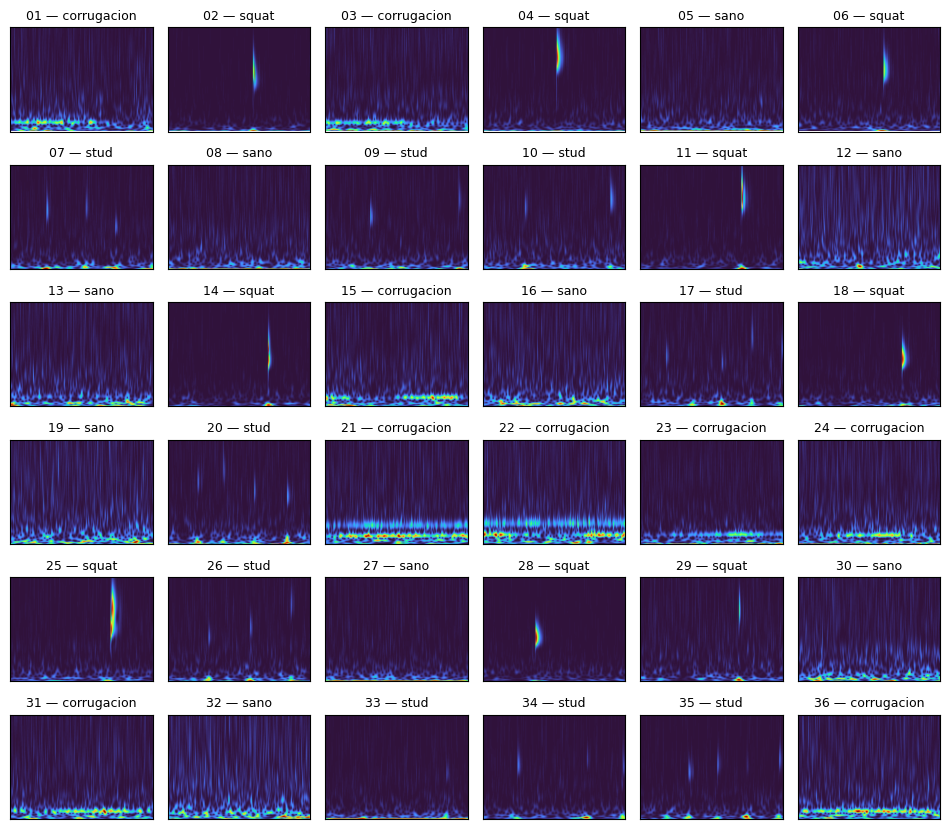

In [21]:
# ============================================================
# 4) PREVISUALIZACIÓN (rejilla) + PNGs de QA opcionales
# ============================================================
if SHOW_PREVIEW and len(all_preview) > 0:
    import math
    rows, cols = PREVIEW_GRID
    n = min(N_PREVIEW, len(all_preview))
    fig, axes = plt.subplots(rows, cols, figsize=(1.6*cols, 1.4*rows), sharex=True, sharey=True)
    axes = np.array(axes).reshape(-1)
    for k in range(rows*cols):
        ax = axes[k]
        if k < n:
            img, lab = all_preview[k]
            if RESIZE_OUTPUT:
                H, W = IMG_SIZE
            else:
                H, W = img.shape
            # Mostrar como imagen con colormap turbo
            ax.imshow(img, origin='lower', aspect='auto', cmap="turbo")
            ax.set_title(f"{k+1:02d} — {lab}", fontsize=9)
        else:
            ax.axis("off")
        ax.set_xticks([]); ax.set_yticks([])
    plt.tight_layout()
    if SAVE_PNG_FOR_QA:
        png_path = os.path.join(OUT_PREVIEW_DIR, f"{QA_PNG_PREFIX}_{N_SIGNALS}.png")
        plt.savefig(png_path, dpi=140)
        print("Previsualización guardada en:", png_path)
    plt.show()